In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Used this notebook:

https://www.kaggle.com/code/taha07/wine-quality-prediction-data-analysis

In [3]:
df = pd.read_csv("wine.csv")

In [4]:
df.columns

Index(['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')

In [5]:
for column in df.columns:
    if df[column].isnull().sum() != 0:
        mean = df[column].mean()
        df[column].fillna(mean,inplace=True)

In [6]:
df.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [21]:
white = pd.get_dummies(df["type"],drop_first=True)
df_clean = pd.concat([df,white],axis=1)
df_clean.drop("type",axis=1,inplace=True)
df_clean.columns = df_clean.columns.str.replace(' ', '_', regex=False)

In [22]:
x = df_clean.drop("quality",axis=True)
y = df_clean["quality"]

In [23]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(x,y)

ExtraTreesClassifier()

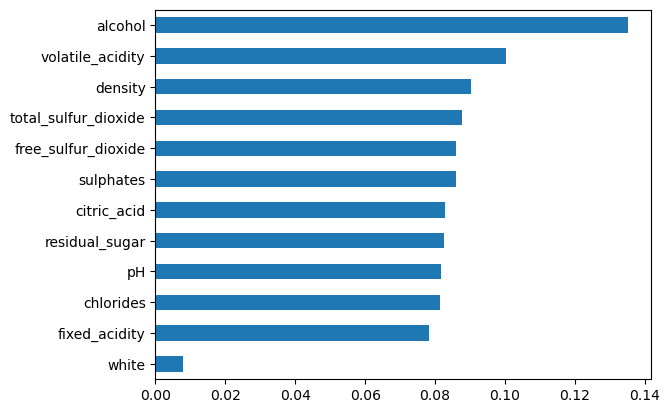

In [24]:
feat_importances = pd.Series(model.feature_importances_,index =x.columns)
feat_importances.sort_values().plot(kind="barh")
plt.show()

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [26]:
model_params  = {
    "svm" : {
        "model":SVC(gamma="auto"),
        "params":{
            'C' : [1,10,20],
            'kernel':["rbf"]
        }
    },
    
    "decision_tree":{
        "model": DecisionTreeClassifier(),
        "params":{
            'criterion':["entropy","gini"],
            "max_depth":[5,8,9]
        }
    },
    
    "random_forest":{
        "model": RandomForestClassifier(),
        "params":{
            "n_estimators":[1,5,10],
            "max_depth":[5,8,9]
        }
    },
    "naive_bayes":{
        "model": GaussianNB(),
        "params":{}
    },
    
    'logistic_regression' : {
        'model' : LogisticRegression(solver='liblinear',multi_class = 'auto'),
        'params': {
            "C" : [1,5,10]
        }
    }
    
}


In [13]:
score=[]
for model_name,mp in model_params.items():
    clf = GridSearchCV(mp["model"],mp["params"],cv=8,return_train_score=False)
    clf.fit(x,y)
    score.append({
        "Model" : model_name,
        "Best_Score": clf.best_score_,
        "Best_Params": clf.best_params_
    })


/home/filip_praca/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=8.
  warnings.warn(
/home/filip_praca/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=8.
  warnings.warn(
/home/filip_praca/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=8.
  warnings.warn(
/home/filip_praca/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=8.
  warnings.warn(
/home/filip_praca/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated

In [14]:
df_params_comparison = pd.DataFrame(score,columns=["Model","Best_Score","Best_Params"])

In [15]:
df_params_comparison

,Model,Best_Score,Best_Params
0,svm,0.444828,"{'C': 1, 'kernel': 'rbf'}"
1,decision_tree,0.521785,"{'criterion': 'entropy', 'max_depth': 5}"
2,random_forest,0.529941,"{'max_depth': 8, 'n_estimators': 10}"
3,naive_bayes,0.380009,{}
4,logistic_regression,0.526253,{'C': 5}


In [27]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [28]:
from sklearn.model_selection import cross_val_score
clf_svm = SVC(kernel="rbf",C=1)
clf_svm.fit(x_train,y_train)

SVC(C=1)

In [29]:
y_pred = clf_svm.predict(x_test)

In [30]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,y_pred)

In [31]:
accuracy

0.42923076923076925

In [32]:
x.shape

(6497, 12)

In [33]:
out = clf_svm.predict(x.iloc[0:1])

In [34]:
x.iloc[0:1].shape

(1, 12)

In [35]:
import hopsworks
import pandas as pd

In [36]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/196772
Connected. Call `.close()` to terminate connection gracefully.


In [ ]:
wine_fg = fs.get_or_create_feature_group(
    name="wine",
    version=1,
    primary_key=df_clean.columns, 
    description="Wine quality dataset")
wine_fg.insert(df_clean)

In [44]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

In [72]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(x_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [73]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
#fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(x_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/196772/models/wine_model/1


Model(name: 'wine_model', version: 1)

In [39]:
max(df_clean["fixed_acidity"])

15.9

In [41]:
for col in df_clean.columns:
    print(f"{col} min: {min(df_clean[col])} max: {max(df_clean[col])}")

fixed_acidity min: 3.8 max: 15.9
volatile_acidity min: 0.08 max: 1.58
citric_acid min: 0.0 max: 1.66
residual_sugar min: 0.6 max: 65.8
chlorides min: 0.009 max: 0.611
free_sulfur_dioxide min: 1.0 max: 289.0
total_sulfur_dioxide min: 6.0 max: 440.0
density min: 0.98711 max: 1.03898
pH min: 2.72 max: 4.01
sulphates min: 0.22 max: 2.0
alcohol min: 8.0 max: 14.9
quality min: 3 max: 9
white min: False max: True
